## Predict Apple stock using LSTM

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1,2,3 .


In [2]:
path = '/Volumes/ExternalSSDForMac/AITLecture/CSforDSAIAUG22/codealongcsfordsaiAti/_14novlstm/appl_1980_2014.csv'

In [3]:
df = pd.read_csv(path,index_col=0,parse_dates=True)
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2014-07-08,96.27,96.80,93.92,95.35,65130000,95.35
2014-07-07,94.14,95.99,94.10,95.97,56305400,95.97
2014-07-03,93.67,94.10,93.20,94.03,22891800,94.03
2014-07-02,93.87,94.06,93.09,93.48,28420900,93.48
2014-07-01,93.52,94.07,93.13,93.52,38170200,93.52


In [4]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [5]:
col_use_name = 'Close'

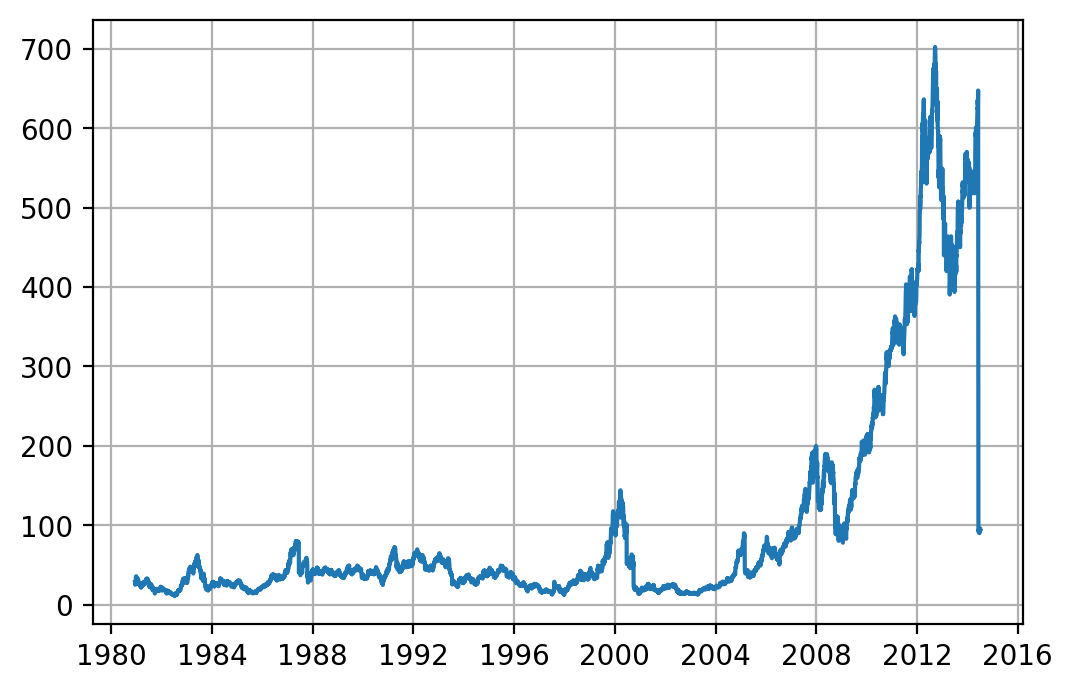

In [6]:
plt.figure(dpi=200)
plt.plot(df[col_use_name])
plt.grid()

In [7]:
y = df[col_use_name].values.astype('float')
y.shape

(8465,)

In [8]:
test_size = 100
tran_set = y[:-test_size]
test_set = y[-test_size:]

In [9]:
len(tran_set),len(test_set)

(8365, 100)

## 4.Preprocessing

In [10]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(-1,1))
train_mm = sc.fit_transform(tran_set.reshape(-1,1))

In [11]:
train_mm = torch.FloatTensor(train_mm).reshape(-1)

In [12]:
train_mm.shape

torch.Size([8365])

# 5. Data batcher

In [13]:
window_size = 10

def input_data(seq, window_size, label_size=1):
    out = []
    total_length = len(seq)
    for i in range(total_length-window_size):  #if not, we will go out of bound
        window = seq[i:i+window_size]
        label  = seq[i+window_size:i+window_size+label_size]
        out.append((window, label))
    return out

#question: if my window is 10, label size is 1, my seq is ???
#        :  then what is the shape of out??? 

In [14]:
train_data = input_data(train_mm, window_size)
len(train_data)

8355

### 6. temp model

In [15]:
class chakyLSTM(nn.Module):
    #why out_size = 1, because later on, we will label_size = 1
    def __init__(self, input_size = 1, hidden_size=100, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm   = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, out_size) #taking the last hidden state
        
        #optional
        #h0, c0
        #(D*num layer, N, Hin)
        self.hidden = (torch.zeros(1, 1, hidden_size),
                       torch.zeros(1, 1, hidden_size))
        
    def forward(self, seq):
        #seq shape: (10)
        seq = seq.reshape(len(seq), 1, -1)
        #seq shape: (10, 1, 1)
        out, (_, _) = self.lstm(seq, self.hidden) #you don't need self.hidden
        #out shape: (L, N, Hout * D) ==> (10, 1, 100)
        out = out[-1, :, :] #(B, Hout)
        #out shape: (1, 100)
        out = self.linear(out)
        #out shape: (1, 1)
        return out
        

In [16]:
torch.manual_seed(112)
model = chakyLSTM()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [17]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model) #why 400?, why 40000????

   400
 40000
   400
   400
   100
     1
______
 41301


## 7.Training

In [18]:
epochs = 2

for e in range(epochs):
    
    for seq, ytrain in train_data:
        #seq: (10, ); target: (1, )
        # print(seq.shape)
        # print(target.shape)
        yhat = model(seq).reshape(-1)
        loss = criterion(yhat,ytrain)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # if e %0 == 0 :
    print(f'{e:2.0f} epich : loss = {loss:2.5f}')
print(f'{e} epich : loss = {loss}')

 0 epich : loss = 0.00006
 1 epich : loss = 0.00001
1 epich : loss = 5.532461273105582e-06


### 8 .plot loss


### 9. inference

In [19]:
future = window_size
## prepare a lsit of predocit ion and append on this list
preds = train_mm[-window_size:].tolist()

# model.eval() # same as no_grad() all bathnorm and dropout are turn off
for _ in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        yghat = model(seq)
        preds.append(yghat)


## 10.Denormalize our data

In [20]:
preds_real = sc.inverse_transform(np.array(preds).reshape(-1,1))

/var/folders/6k/k4c4b7k97xg5ynmwn30pdxtr0000gn/T/ipykernel_10358/1483272989.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preds_real = sc.inverse_transform(np.array(preds).reshape(-1,1))


In [22]:
preds_real[-10:],test_set[-10:]

(array([[28.4815731 ],
        [28.56554456],
        [28.56519442],
        [28.56447355],
        [28.56404103],
        [28.56465892],
        [28.5653592 ],
        [28.56593589],
        [28.56638902],
        [28.56663617]]),
 array([35.5 , 32.5 , 30.88, 29.63, 28.25, 26.63, 25.87, 25.25, 27.25,
        28.75]))

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8465 entries, 2014-07-08 to 1980-12-12
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       8465 non-null   float64
 1   High       8465 non-null   float64
 2   Low        8465 non-null   float64
 3   Close      8465 non-null   float64
 4   Volume     8465 non-null   int64  
 5   Adj Close  8465 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 462.9 KB


In [36]:
future = 100

Loss: 5.532461273105582e-06


/var/folders/6k/k4c4b7k97xg5ynmwn30pdxtr0000gn/T/ipykernel_10358/1433785578.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preds_real = sc.inverse_transform(np.array(preds).reshape(-1,1))


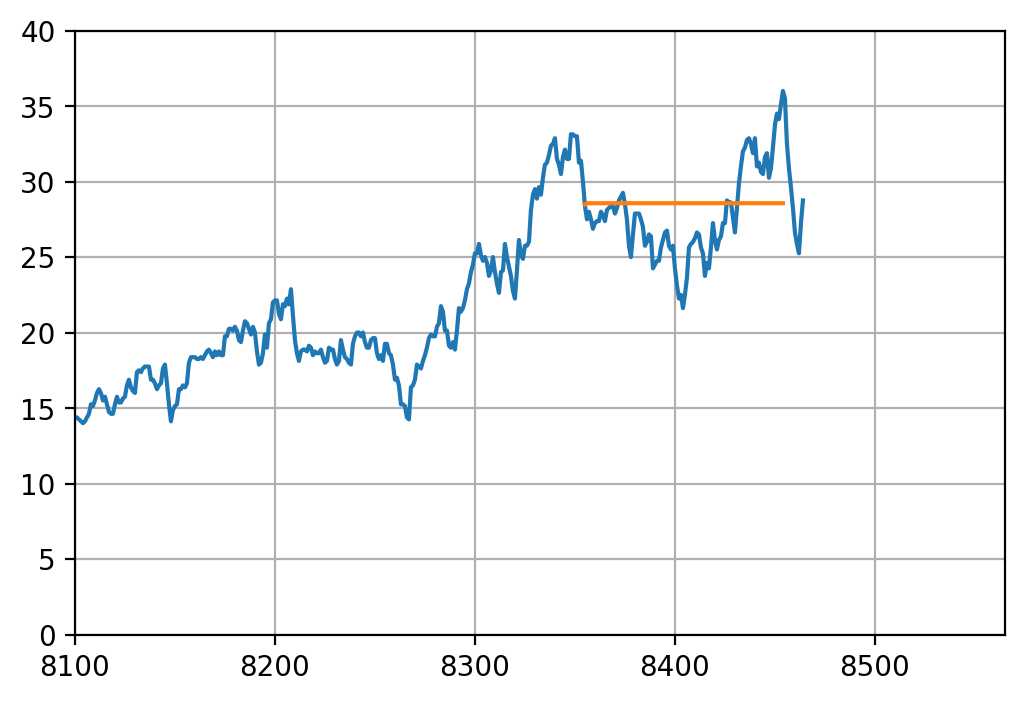

In [50]:
preds = train_mm[-window_size:].tolist()

for _ in range(future):  #looking into the future
    seq = torch.FloatTensor(preds[-window_size:]) 
    with torch.no_grad():
        yhat = model(seq)
        preds.append(yhat)
        
print(f'Loss: {loss}')

preds_real = sc.inverse_transform(np.array(preds).reshape(-1,1))

plt.figure(dpi = 200)
plt.xlim(8100,8565)
plt.ylim(0,40)
plt.grid(True)
plt.plot(y)

plt.plot(np.arange(8355,8455),torch.tensor(preds_real[-100:]))

plt.show()

In [48]:
# preds[-100:]